In [43]:
import os
import sys
import json
import glob
parent_dir = os.path.dirname(os.getcwd())
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

In [44]:
!{sys.executable} -m pip install numpy

In [45]:
import SimpleITK as sitk

from volumetry.plotting import *
from volumetry.methods import ellipsoid_method, voxels_volume
from volumetry.utils import divide_image, find_kidney_slices
import numpy as np
from skimage.feature import canny
from skimage.transform import hough_ellipse
from skimage.draw import ellipse_perimeter

In [64]:
examples = [file for file in os.listdir('../data/mat') if not file.startswith('.')]
with open('results.jsonl', 'w') as f:
    for example in examples:
        data = os.path.join('../data/mat', example, 'result')
        #image_path = next((file for file in glob.glob(os.path.join(data, '*_25.mhd')) 
        #                   if not file.startswith('._')))
        segmentation_path = next((file for file in glob.glob(os.path.join(data, '*.nii')) 
                                  if not file.startswith('._')))

        #image = sitk.ReadImage(image_path, sitk.sitkFloat32)
        segmentation = sitk.ReadImage(segmentation_path, sitk.sitkFloat32)

        #left_image, right_image = divide_image(image)
        left_segmentation, right_segmentation = divide_image(segmentation)

        left_volume = voxels_volume(segmentation, left_segmentation, seg_val=6)
        right_volume = voxels_volume(segmentation, right_segmentation, seg_val=6)
        if left_volume != 0 and right_volume != 0:
            print('error', example)
            continue
        elif left_volume == 0:
            seg = right_segmentation
            ref_vol = right_volume
        else:
            seg = left_segmentation
            ref_vol = left_volume

        first, last, max_idx = find_kidney_slices(seg, seg_val=6)
        edges = canny(seg[max_idx])

        ellipses = hough_ellipse(edges)
        print(len(ellipses))
        ellipses = np.array([params for params in ellipses if params['a'] != 0 and params['b'] > 15])
        ellipses.sort(order=['a', 'b'])
        param = list(ellipses[-1])


        yc, xc, a, b = [int(round(x)) for x in param[1:5]]
        print(a, b)
        orientation = param[5]
        xs, ys = ellipse_perimeter(yc, xc, a, b, orientation)
        
        c = last - first
        a_s, b_s, c_s = segmentation.GetSpacing()
        volume = a * b * c * a_s * b_s * c_s * np.pi * (2 / 3)
        f.write(json.dumps({
            'example_id': example,
            'volume': volume,
            'ref_volume': ref_vol,
            'a': a*a_s,
            'b': b*b_s,
            'c': c*c_s
        }))
        f.write('\n')
        print(volume, ref_vol)

28726
45 30
176481.6673612778 112504.29531097412
13998
35 35
141612.97677343708 93759.48282241821
12844
38 38
206383.34629407182 138236.66518688202
12032
37 31
186284.5176572489 165309.67712402344
47372
49 49
298375.8684659438 182285.65509796143
27790
44 27
97783.841831041 79512.28339207149
26874
36 30
168127.70745951933 136419.57237243652
13358
43 27
218192.60119623085 123123.9033126831
error 23640
68958
52 17
99869.10487236951 151270.27628615015
12007
34 34
230499.96430777226 188048.71830940247
13525
47 47
302042.92210386624 178402.27035999298
9916
33 16
95554.53565642191 134246.28719329834
16532
35 35
177417.08904546755 126487.00824737549
14382
35 35
201798.47562346444 110651.27134491349
22062
36 20
118162.77977532905 138600.79908370972
11050
33 33
202134.59465781556 136279.11333084106
8895
34 31
154837.05503298668 116961.533203125
29352
53 37
265850.6280239518 181833.31998825073
23721
52 30
219144.3803087836 138149.69287872314
21231
51 18
138445.4920022022 105661.5390586853
12139
4

In [61]:
segmentation.GetSpacing()

(0.94140625, 0.94140625, 1.25)

In [62]:
image_path = '../data/mat/1149/20181126_ser501A4_371/CT_S501_A4_SpacingBetweenSlices1_25.mhd'
segmentation_path = '../data/mat/1149/20181126_ser501A4_371/1149 2018 11 26 A AVTKP.nii'

In [14]:
image = sitk.ReadImage(image_path, sitk.sitkFloat32)
segmentation = sitk.ReadImage(segmentation_path, sitk.sitkFloat32)

In [15]:
left_image, right_image = divide_image(image)
left_segmentation, right_segmentation = divide_image(segmentation)

In [16]:
left_image.shape

(370, 512, 256)

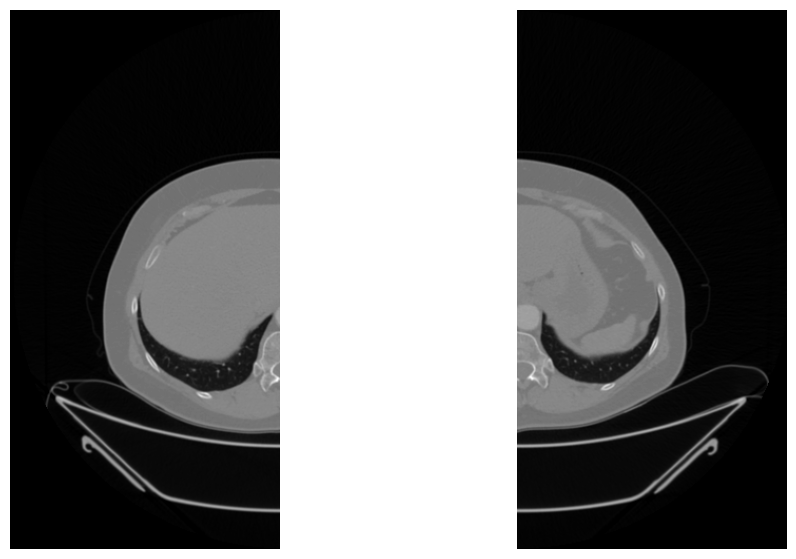

In [17]:
plot_two_images(left_image[70], right_image[70])

In [18]:
voxels_volume(segmentation, left_segmentation, seg_val=6)

0.0

In [19]:
voxels_volume(segmentation, right_segmentation, seg_val=6)

125728.84559631348

In [21]:
first, last, max_idx = find_kidney_slices(right_segmentation, seg_val=6)
# volume, xs, ys = ellipsoid_method(left_segmentation[max_idx], first, last)
# volume

In [24]:
from skimage.feature import canny
from skimage.transform import hough_ellipse
from skimage.draw import ellipse_perimeter

edges = canny(right_segmentation[max_idx])

ellipses = hough_ellipse(edges)
print(len(ellipses))
ellipses = np.array([params for params in ellipses if params['a'] != 0 and params['b'] > 15])
ellipses.sort(order=['a', 'b'])
param = list(ellipses[-1])


yc, xc, a, b = [int(round(x)) for x in param[1:5]]
print(a, b)
orientation = param[5]
xs, ys = ellipse_perimeter(yc, xc, a, b, orientation)

c = last - first
volume = a * b * c * np.pi * (2 / 3)

14384
34 24


In [31]:
c

78

In [32]:
volume

133304.0594771221

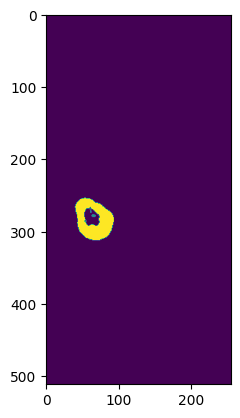

In [35]:
plt.imshow(right_segmentation[max_idx])

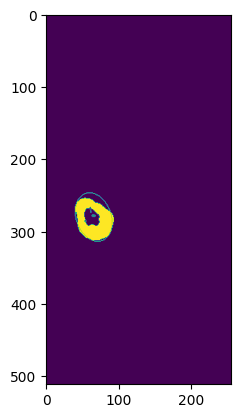

In [34]:
import numpy as np
import matplotlib.pyplot as plt

ellipse_image = np.copy(right_segmentation[max_idx])
ellipse_image[xs, ys] = 5
plt.imshow(ellipse_image)
plt.show()